In [1]:
import os
from helper import init_ipynb
envfound = init_ipynb()

DIR = os.environ["DIR_PATH"] if envfound else None
DEVICE = os.environ["DEVICE"] if envfound else None
API_KEY = os.environ["API_KEY"] if envfound else None
PLATFORM = os.environ["OS_TYPE"] if envfound else None
%load_ext autoreload
%autoreload 2

In [2]:
from models import ( HF_LLM, GenerationArg, Model)
from evaluation import MCQBenchmark
import gc

if(PLATFORM == "Linux"):
    from vllm.model_executor.parallel_utils.parallel_state import destroy_model_parallel
import torch.distributed
from typing import List, Callable
import pandas as pd
from models.qa_prompts import QA_PROMPTS


import nltk
nltk.download('punkt')

def cot_prompt_template(n_shots: int, q: str, stop_token:str="###") -> str:
    template = QA_PROMPTS["cot_answer_align"]
    shots = '\n'.join(template['shots'][:n_shots])
    return f"""-system:\n{template['system']}\n{shots}{template['q_form'].format(q=q)}""".replace("###", stop_token)

def direct_prompt_template(n_shots: int, q: str, stop_token:str="###") -> str:
    template = QA_PROMPTS["direct_answer_align"]
    shots = '\n'.join(template['shots'][:n_shots])
    return f"""-system:\n{template['system']}\n{shots}{template['q_form'].format(q=q)}""".replace("###", stop_token)

def cot1_prompt_template_support(q: str, shots: List[str], stop_token:str="###") -> str:
    template = QA_PROMPTS["1cot_answer_align"]
    shots = '\n'.join(shots)
    return f"""-system:\n{template['system']}\n{shots}{template['q_form'].format(q=q)}""".replace("###", stop_token)

def cot1_prompt_template(n_shots: int, q: str, stop_token:str="###") -> str:
    template = QA_PROMPTS["1cot_answer_align"]
    shots = '\n'.join(template[shots][:n_shots])
    return f"""-system:\n{template['system']}\n{shots}{template['q_form'].format(q=q)}""".replace("###", stop_token)


def search_ans(pred):
    if(type(pred) != str):
        pred = pred.outputs[0].text
    ans_sentence = [x for x in pred.split(".") if "Therefore" in x]
    

    if(ans_sentence == []):
        return "-1"
    sel = [l for l in ["A", "B", "C", "D", "E"] if l in ans_sentence[0]]
    return sel[0] if sel != [] else "-1"


FLAGS = ["Therefore", "correct", "answer"]
def match_score(sentence):
    return len([flag for flag in FLAGS if flag in sentence]) / len(FLAGS)

def simple_extract(ans_sentence):
    sel = [l for l in ["A", "B", "C", "D", "E"] if l in ans_sentence]
    return sel[0] if sel != [] else "-1"

def csa2(pred):
    if(type(pred) != str):
        pred = pred.outputs[0].text
    sent_text = nltk.sent_tokenize(pred.replace("\n", "??"))
    sentence_score = sorted([[sent, match_score(sent)] for sent in sent_text], key=lambda _: _[1], reverse=True)
    if(len(sentence_score) == 0):
        return "-1"
    sentence, score = sentence_score[0]
    if(score == 0):
        return "-1"
    return simple_extract(sentence)



def write_cache(cache_file:str,
                res,
                targets:List[str]):
    total_cache_file = "docs/benchmarks_results/full/" + cache_file
    with open(total_cache_file) as f:
        singleqa = [f"{res[i].outputs[0].text}\n\n{targets[i]}\n\n{'*'*100}" for i in range(len(targets))]
        f.write("\n\n".join(singleqa))
    print(f"Cached full results on : {cache_file}")


def benchmark(llm: Model,
              benchnames: List[str],
              pt: Callable[[str], str],
              search_ans: Callable[[str], str],
              cache_file:str | None=None,
              support_type:str | None=None,
              n_shots:int | None=3):
    """
        args :
            - model: model to test
            - benchnames : names of the benchmarks to run for the given model
            - pt : prompt template that inputs a question and return the prompt to the model
            - search_ans : a function that finds the answer to the MCQ in the result string
    """
    model_res = []
    for benchname in benchnames:
        print("Evaluation on", benchname)
        benchmark = MCQBenchmark(
            BENCHMARKS_PATHS[benchname],
            pt, ## call with the specific prompt template
            support_type=support_type,
            n_shots=n_shots
        )
        res = benchmark.assess(llm)
        
        if(cache_file is not None):
            ## if a cache_file is inputed => cache out the file
            write_cache(
                cache_file,
                res,
                [q["answer"] for q in benchmark.mcq]
            )
            

        answ = []
        for r in res:
            answ.append(search_ans(r))
        
        model_res.append(
            sum(q["answer"] in ans for ans, q in zip(answ, benchmark.mcq)) / len(answ)
        )
    return model_res


def testbench(
    benchnames:List[str]=["AES7", "AES8"],
    modnames:List[str]=["epfl-llm/meditron-7b", "meta-llama/Llama-2-7b-hf"],
    runargs:List[GenerationArg]=[],
    prompt_template:Callable[[str], str]=lambda x : x,
    search_ans:Callable[[str], str]=lambda x : x,
    use_vllm:bool=True,
    cache_file:str | None=None,
    support_type:str | None=None,
    n_shots:int | None=3,
    ) -> pd.DataFrame:
    
    all_res = []
    for mod in modnames:
        print("<" + "-" * 100 + ">")
        try : 
        ## creating and loading the model
            llm = HF_LLM(
                        mod,
                        device=DEVICE,
                        use_vllm=use_vllm,
                        arg=GenerationArg(use_vllm=use_vllm)
                    )
            llm.load()

            for runarg in runargs:
                ## update the model with current runargs
                llm.set_arg(runarg)

                ## run the benchmarks
                rr = [mod] \
                    + [v for k, v in runarg.attr.items()] \
                    + benchmark(llm, benchnames, prompt_template, search_ans, cache_file, support_type, n_shots) 
                all_res.append(rr)
            destroy_model_parallel()
            del llm
            gc.collect()
            torch.cuda.empty_cache()
            # torch.distributed.destroy_process_group()
        except Exception as e:    
            ## unload the model
            print("Unloading the model")
            destroy_model_parallel()
            del llm
            gc.collect()
            torch.cuda.empty_cache()
            # torch.distributed.destroy_process_group()
            raise Exception(e)
    cols = ["mod"] + [k for k, v in runargs[0].attr.items()] + benchnames
    return pd.DataFrame(all_res, columns=cols)

BENCHMARKS_PATHS = {
    "MCQ" : "docs/benchmarks/mcq40/processed.json",
    "AES7" : "docs/benchmarks/self_assessment/aes7_processed.json",
    "AES8" :  "docs/benchmarks/self_assessment/aes8_processed.json",
    "AES9" :  "docs/benchmarks/self_assessment/aes9_processed.json",
    "FULL" :  "docs/benchmarks/self_assessment/final_processed.json",
}

/opt/homebrew/Caskroom/miniconda/base/envs/nlp1/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp1/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp1/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


We've set API key :  44221d61cf68a2c739480afa93025176


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/antoinemagron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Ablation studies


### Ablation on number of shots for COT1

In [16]:
modnames = ["epfl-llm/meditron-7b", "meta-llama/Meta-Llama-3-8B", "meta-llama/Llama-2-7b-hf"]
benchnames = ["AES7", "AES8"]
DETERMINISTIC = GenerationArg(
        temperature=0.001,
        use_vllm=True,
        topk=1,
        topp=1,
        max_new_token=512,
        stop_seq="<|STOP|>"
    )

In [4]:
results = []
for shots in range(4):
    resdf = testbench(benchnames=benchnames,
              runargs=[DETERMINISTIC],
              prompt_template=lambda q : cot1_prompt_template(shots, q, stop_token="<|STOP|>"),
              search_ans=search_ans,
              modnames=modnames,
              use_vllm=True)
    resdf["shots"] = shots
    results.append(resdf)

<---------------------------------------------------------------------------------------------------->
INFO 05-14 10:30:05 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='epfl-llm/meditron-7b', tokenizer='epfl-llm/meditron-7b', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 05-14 10:30:05 selector.py:51] Cannot use FlashAttention because the package is not found. Please install it for better performance.
INFO 05-14 10:30:05 selector.py:25] Using XFormers backend.
INFO 05-14 10:30:06 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 05-14 10:30:07 model_runner.py:104] Loading model weights took 12.5527 GB
INFO 05-14 10:30:08 gpu_executor.py:94] # GPU blocks: 3797, # CPU blocks: 512
INFO 05-14 10:30:09 model_runner.py:791] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 05-14 10:30:09 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 05-14 10:30:14 model_runner.py:867] G

Processed prompts: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Evaluation on AES8


Processed prompts: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


<---------------------------------------------------------------------------------------------------->
INFO 05-14 10:31:52 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='meta-llama/Meta-Llama-3-8B', tokenizer='meta-llama/Meta-Llama-3-8B', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 05-14 10:31:52 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 05-14 10:31:54 model_runner.py:104] Loading model weights took 14.9595 GB
INFO 05-14 10:31:55 gpu_executor.py:94] # GPU blocks: 13450, # CPU blocks: 2048
INFO 05-14 10:31:55 model_runner.py:791] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 05-14 10:31:55 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 05-14 10:32:01 model_runner.py:867] Graph capturing finished in 5 secs.
Evaluation on AES7


Processed prompts: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Evaluation on AES8


Processed prompts: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


<---------------------------------------------------------------------------------------------------->
INFO 05-14 10:32:41 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='meta-llama/Llama-2-7b-hf', tokenizer='meta-llama/Llama-2-7b-hf', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)
INFO 05-14 10:32:41 selector.py:51] Cannot use FlashAttention because the package is not found. Please install it for better performance.
INFO 05-14 10:32:41 selector.py:25] Using XFormers backend.
INFO 05-14 10:32:41 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 05-14 10:32:42 model_runner.py:104] Loading model weights took 12.5523 GB
INFO 05-14 10:32:43 gpu_executor.py:94] # GPU blocks: 3819, # 

Processed prompts: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Evaluation on AES8


Processed prompts: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


<---------------------------------------------------------------------------------------------------->
INFO 05-14 10:33:28 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='epfl-llm/meditron-7b', tokenizer='epfl-llm/meditron-7b', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 05-14 10:33:28 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 05-14 10:33:30 model_runner.py:104] Loading model weights took 12.5523 GB
INFO 05-14 10:33:30 gpu_executor.py:94] # GPU blocks: 3826, # CPU blocks: 512
INFO 05-14 10:33:30 model_runner.py:791] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 05-14 10:33:30 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 05-14 10:33:35 model_runner.py:867] Graph capturing finished in 5 secs.
Evaluation on AES7


Processed prompts: 100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


Evaluation on AES8


Processed prompts: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]


<---------------------------------------------------------------------------------------------------->
INFO 05-14 10:34:47 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='meta-llama/Meta-Llama-3-8B', tokenizer='meta-llama/Meta-Llama-3-8B', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 05-14 10:34:47 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 05-14 10:34:49 model_runner.py:104] Loading model weights took 14.9575 GB
INFO 05-14 10:34:50 gpu_executor.py:94] # GPU blocks: 13450, # CPU blocks: 2048
INFO 05-14 10:34:50 model_runner.py:791] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 05-14 10:34:50 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 05-14 10:34:55 model_runner.py:867] Graph capturing finished in 5 secs.
Evaluation on AES7


Processed prompts: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Evaluation on AES8


Processed prompts: 100%|██████████| 100/100 [00:33<00:00,  2.94it/s]


<---------------------------------------------------------------------------------------------------->
INFO 05-14 10:36:03 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='meta-llama/Llama-2-7b-hf', tokenizer='meta-llama/Llama-2-7b-hf', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)
INFO 05-14 10:36:04 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 05-14 10:36:05 model_runner.py:104] Loading model weights took 12.5513 GB
INFO 05-14 10:36:06 gpu_executor.py:94] # GPU blocks: 3819, # CPU blocks: 512
INFO 05-14 10:36:06 model_runner.py:791] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set

Processed prompts: 100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


Evaluation on AES8


Processed prompts: 100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


<---------------------------------------------------------------------------------------------------->
INFO 05-14 10:37:01 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='epfl-llm/meditron-7b', tokenizer='epfl-llm/meditron-7b', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 05-14 10:37:01 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 05-14 10:37:03 model_runner.py:104] Loading model weights took 12.5523 GB
INFO 05-14 10:37:03 gpu_executor.py:94] # GPU blocks: 3826, # CPU blocks: 512
INFO 05-14 10:37:03 model_runner.py:791] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 05-14 10:37:03 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 05-14 10:37:08 model_runner.py:867] Graph capturing finished in 5 secs.
Evaluation on AES7


Processed prompts: 100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


Evaluation on AES8


Processed prompts: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


<---------------------------------------------------------------------------------------------------->
INFO 05-14 10:38:35 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='meta-llama/Meta-Llama-3-8B', tokenizer='meta-llama/Meta-Llama-3-8B', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 05-14 10:38:35 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 05-14 10:38:37 model_runner.py:104] Loading model weights took 14.9575 GB
INFO 05-14 10:38:38 gpu_executor.py:94] # GPU blocks: 13450, # CPU blocks: 2048
INFO 05-14 10:38:38 model_runner.py:791] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 05-14 10:38:38 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 05-14 10:38:43 model_runner.py:867] Graph capturing finished in 5 secs.
Evaluation on AES7


Processed prompts: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


Evaluation on AES8


Processed prompts: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


<---------------------------------------------------------------------------------------------------->
INFO 05-14 10:40:11 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='meta-llama/Llama-2-7b-hf', tokenizer='meta-llama/Llama-2-7b-hf', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)
INFO 05-14 10:40:11 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 05-14 10:40:13 model_runner.py:104] Loading model weights took 12.5513 GB
INFO 05-14 10:40:14 gpu_executor.py:94] # GPU blocks: 3819, # CPU blocks: 512
INFO 05-14 10:40:14 model_runner.py:791] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set

Processed prompts: 100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


Evaluation on AES8


Processed prompts: 100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


<---------------------------------------------------------------------------------------------------->
INFO 05-14 10:41:26 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='epfl-llm/meditron-7b', tokenizer='epfl-llm/meditron-7b', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 05-14 10:41:26 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 05-14 10:41:28 model_runner.py:104] Loading model weights took 12.5523 GB
INFO 05-14 10:41:29 gpu_executor.py:94] # GPU blocks: 3826, # CPU blocks: 512
INFO 05-14 10:41:29 model_runner.py:791] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 05-14 10:41:29 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 05-14 10:41:34 model_runner.py:867] Graph capturing finished in 5 secs.
Evaluation on AES7


Processed prompts: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Evaluation on AES8


Processed prompts: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


<---------------------------------------------------------------------------------------------------->
INFO 05-14 10:43:08 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='meta-llama/Meta-Llama-3-8B', tokenizer='meta-llama/Meta-Llama-3-8B', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 05-14 10:43:08 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 05-14 10:43:10 model_runner.py:104] Loading model weights took 14.9575 GB
INFO 05-14 10:43:11 gpu_executor.py:94] # GPU blocks: 13450, # CPU blocks: 2048
INFO 05-14 10:43:11 model_runner.py:791] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 05-14 10:43:11 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 05-14 10:43:16 model_runner.py:867] Graph capturing finished in 5 secs.
Evaluation on AES7


Processed prompts: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Evaluation on AES8


Processed prompts: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


<---------------------------------------------------------------------------------------------------->
INFO 05-14 10:44:54 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='meta-llama/Llama-2-7b-hf', tokenizer='meta-llama/Llama-2-7b-hf', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)
INFO 05-14 10:44:55 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 05-14 10:44:56 model_runner.py:104] Loading model weights took 12.5513 GB
INFO 05-14 10:44:57 gpu_executor.py:94] # GPU blocks: 3819, # CPU blocks: 512
INFO 05-14 10:44:57 model_runner.py:791] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set

Processed prompts: 100%|██████████| 100/100 [00:32<00:00,  3.03it/s]


Evaluation on AES8


Processed prompts: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


In [5]:
pd.concat(results).to_csv("docs/benchmarks_results/ablation_study.csv")

## Study the results

In [5]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

BENCHMARKS_PATHS = {
    "MCQ" : "docs/benchmarks/mcq40/processed.json",
    "AES7" : "docs/benchmarks/self_assessment/aes7_processed.json",
    "AES8" :  "docs/benchmarks/self_assessment/aes8_processed.json",
}


human_accuracies = {
    "AES7" : sum([_["human_accuracy"] for _ in MCQBenchmark(BENCHMARKS_PATHS["AES7"], lambda x : x).mcq]) / 100,
    "AES8" : sum([_["human_accuracy"] for _ in MCQBenchmark(BENCHMARKS_PATHS["AES8"], lambda x : x).mcq]) / 100,
}

human_accuracies["AES"] = sum(s for b, s in human_accuracies.items()) / len(human_accuracies)

GPT_RES_AES7 = 0.41
GPT_RES_AES8 = 0.43

In [7]:
df = pd.read_csv("docs/benchmarks_results/ablation_study.csv").drop("Unnamed: 0", axis=1)
df.count()

mod                  12
temperature          12
top_k                12
top_p                12
max_tokens           12
presence_penalty     12
frequency_penalty    12
use_beam_search      12
logprobs             12
best_of              12
stop                 12
use_vllm             12
AES7                 12
AES8                 12
shots                12
dtype: int64

In [19]:
def perf_plot(df, against="temp", benchnames=["AES7", "AES8"]):
    colors = ["#a1dab4", "#41b6c4", "#2c7fb8", "#253494", "#ffffcc"]
    temps = []
    for bench in benchnames:
        temp = df[["mod", bench, against]]
        temp["bench"] = bench
        temp.columns = ["mod", "accuracy", against, "bench"]
        temps.append(temp)
    df = pd.concat(temps)

    df["lines"] = df["mod"].apply(process_mod_name) + " on " + df["bench"]
    
    f, a = plt.subplots(figsize=(10, 5))
    for bench, color in zip(benchnames, colors):
        a.axhline(human_accuracies[bench], linestyle="--", label=f"human score {bench} ", color=color)
    a.axhline((GPT_RES_AES7 + GPT_RES_AES8) / 2 , linestyle="--", label=f"GPT3.5 {bench} ", color="r")
    # a.axhline(0.2 , linestyle="--", label=f"chance", color="b")
    g = sns.lineplot(data=df, x=against, y="accuracy", hue="lines")
    g.set_xlabel(f"Generation {against}")
    g.set_ylabel("Accuracy on benchmark")
    xticks = df.sort_values(against)[against].drop_duplicates().values
    g.set_xticks(xticks)
    g.set_xticklabels(xticks)

def process_mod_name(modname):
    return "-".join(modname.split("/")[1].split("-")[:2])

/tmp/ipykernel_3931326/3573217739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["bench"] = bench
/tmp/ipykernel_3931326/3573217739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["bench"] = bench


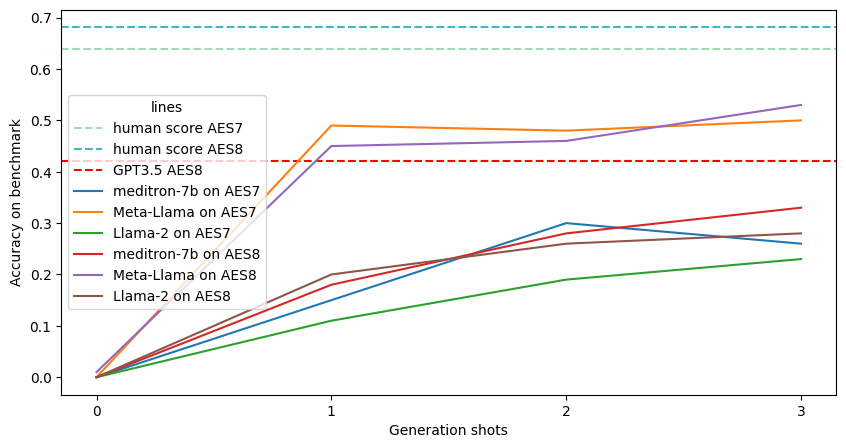

In [9]:
perf_plot(df, against="shots")

In [10]:
print(df.groupby(["mod", "shots"]).agg({"AES7": "mean", "AES8": "mean"}).apply(lambda _ : round(_, 2)).to_latex())

\begin{tabular}{llrr}
\toprule
 &  & AES7 & AES8 \\
mod & shots &  &  \\
\midrule
\multirow[t]{4}{*}{epfl-llm/meditron-7b} & 0 & 0.000000 & 0.000000 \\
 & 1 & 0.150000 & 0.180000 \\
 & 2 & 0.300000 & 0.280000 \\
 & 3 & 0.260000 & 0.330000 \\
\cline{1-4}
\multirow[t]{4}{*}{meta-llama/Llama-2-7b-hf} & 0 & 0.000000 & 0.000000 \\
 & 1 & 0.110000 & 0.200000 \\
 & 2 & 0.190000 & 0.260000 \\
 & 3 & 0.230000 & 0.280000 \\
\cline{1-4}
\multirow[t]{4}{*}{meta-llama/Meta-Llama-3-8B} & 0 & 0.000000 & 0.010000 \\
 & 1 & 0.490000 & 0.450000 \\
 & 2 & 0.480000 & 0.460000 \\
 & 3 & 0.500000 & 0.530000 \\
\cline{1-4}
\bottomrule
\end{tabular}



### Type of shots selection (demonstration retrieval)

In [ ]:
results = []
for support_type in ["deterministic", "kNN"]:
    print("<" + "-" * 30 + " "* 3 + support_type + " " * 3 + "-"* 30 + ">") 
    n_shots = 3
    resdf = testbench(benchnames=benchnames,
            runargs=[DETERMINISTIC],
            prompt_template=lambda q, shots : cot1_prompt_template_support(q, shots, stop_token="<|STOP|>"),
            search_ans=search_ans,
            modnames=modnames,
            use_vllm=True,
            n_shots=n_shots,
            support_type=support_type
            )
    resdf["shots"] = n_shots
    resdf["support_type"] = support_type
    results.append(resdf)

In [ ]:
results = []
support_type = "random"
n_shots = 3
for _ in range(5):
    resdf = testbench(benchnames=benchnames,
            runargs=[DETERMINISTIC],
            prompt_template=lambda q, shots : cot1_prompt_template_support(q, shots, stop_token="<|STOP|>"),
            search_ans=search_ans,
            modnames=modnames,
            use_vllm=True,
            n_shots=n_shots,
            support_type=support_type
            )
    resdf["shots"] = n_shots
    resdf["support_type"] = support_type
    results.append(resdf)

In [21]:
df = pd.concat(results)
df.to_csv("docs/support_type_analysis.csv")

In [62]:
df = pd.read_csv("docs/support_type_analysis.csv")

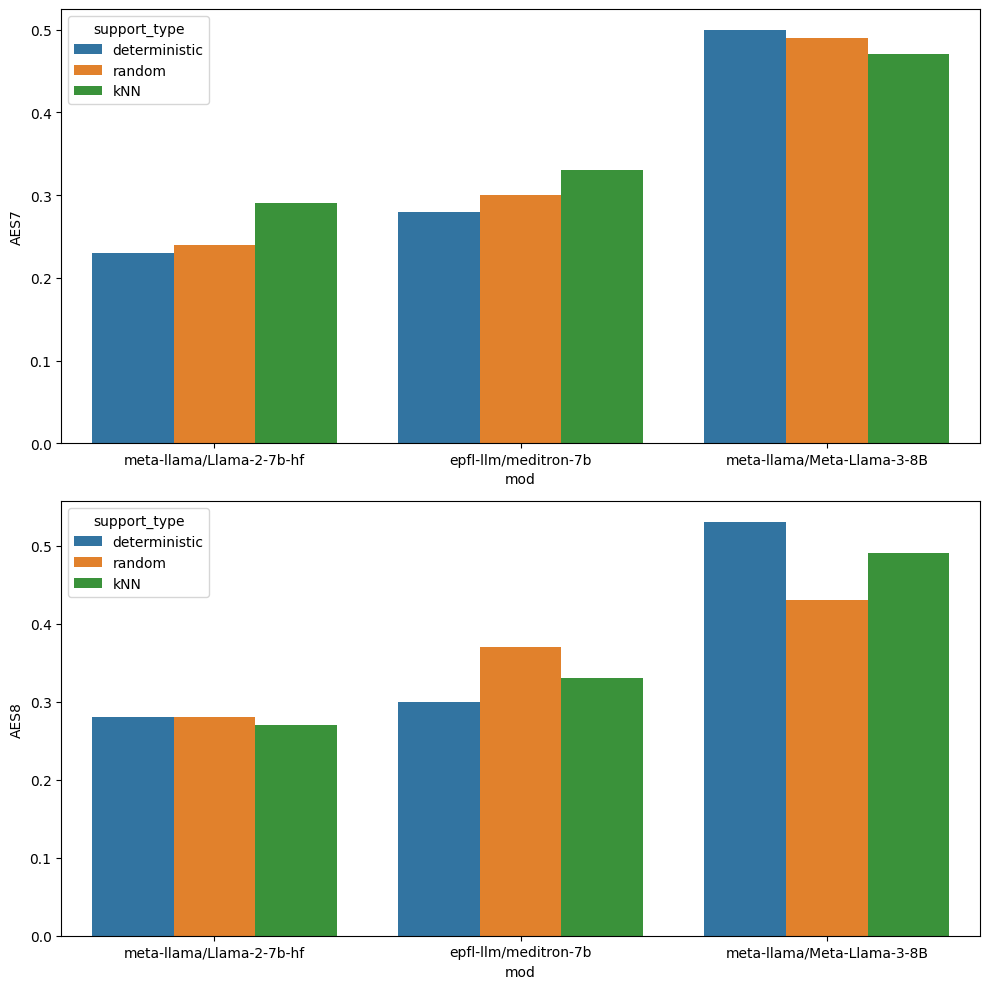

In [30]:
df = df.sort_values("AES7")
f, a = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(
    data=df,
    y="AES7",
    hue="support_type",
    x="mod",
    ax=a[0]
)
sns.barplot(
    data=df,
    y="AES8",
    hue="support_type",
    x="mod",
    ax=a[1]
)
plt.tight_layout()

<ins>Conclusion:</ins> The smaller models benefits from kNN and even randomness while LLaMa-3 benefits more from well crafted prompts.



Adding ChatGPT to this ablation study

In [4]:
from models import OpenAIGPT

MARKER = "X00A"

def cot1_prompt_template_gpt(q: str, shots: List[str]) -> List[str]:
    template = QA_PROMPTS["1cot_answer_align"]
    messages = [
        {
            "role": "system",
            "content": template["system"]
        }
    ]
    for shot in shots:
        contents = shot.replace("-user:", MARKER).replace("-assistant:", MARKER).split(MARKER)
        contents = [x.strip() for x in contents if x != ""]
        messages.append({
            "role": "user",
            "content": contents[0]
        })
        messages.append({
            "role": "assistant",
            "content": contents[1]
        })
    messages.append({
        "role": "user",
        "content": ("Question : " + q)
    })
    return messages


gpt = OpenAIGPT(model="gpt-3.5-turbo")
gpt.set_key(API_KEY)


results = []
for support_type in ["deterministic", "random", "kNN"]:
    print("<" + "-" * 100 + ">")
    for _ in range(5 if support_type == "random" else 1):
        results.append(
            MCQBenchmark(
                BENCHMARKS_PATHS["AES7"],
                cot1_prompt_template_gpt,
                support_type=support_type,
                n_shots=3
            ).assess(gpt)
        )
        results.append(
            MCQBenchmark(
                BENCHMARKS_PATHS["AES8"],
                cot1_prompt_template_gpt,
                support_type=support_type,
                n_shots=3
            ).assess(gpt)
        )

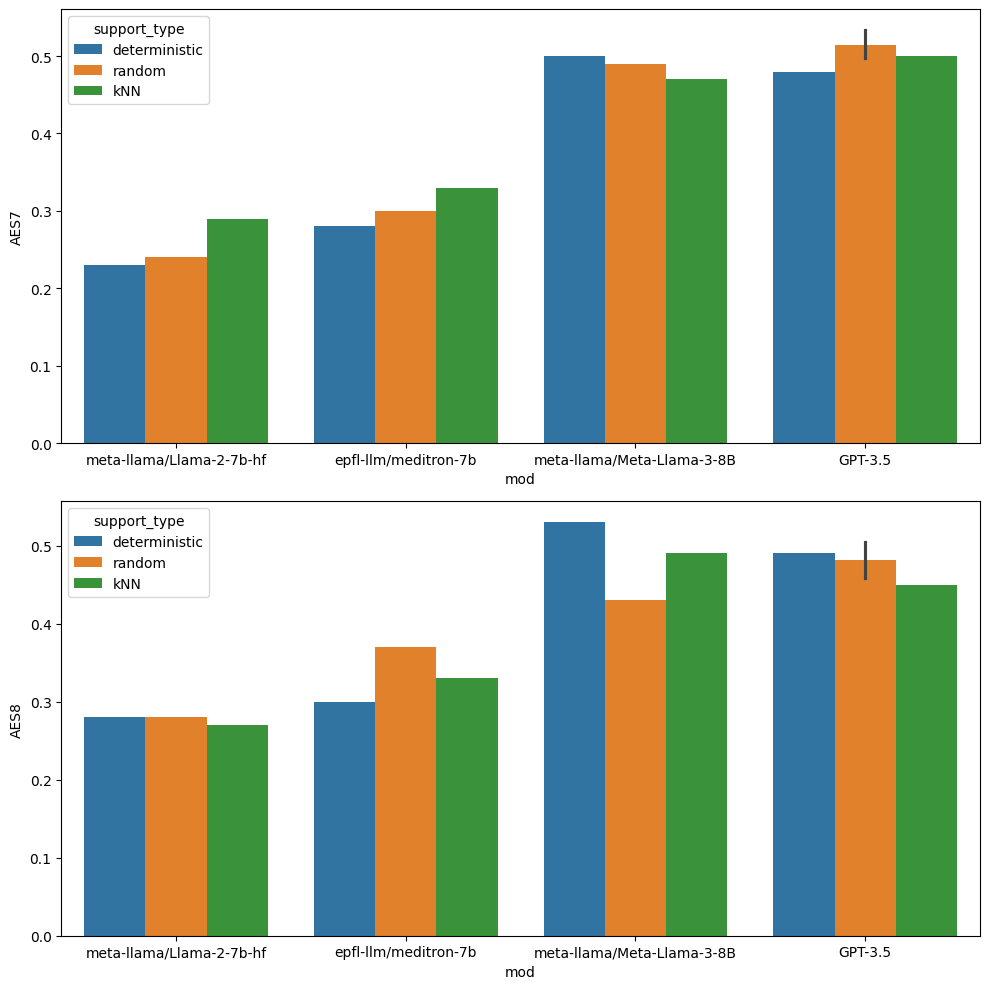

In [67]:
gpt_res = []
for exp in results:
    acc = 0
    for sample in exp:
        acc += int(sample["answer"] == csa2(sample["prediction"]))
    gpt_res.append(
        acc / 100
    )
aes7_gpt_res = gpt_res[::2]
aes8_gpt_res = gpt_res[1::2]
support_types = []
models = []
benchs = []
for support_type in ["deterministic", "random", "kNN"]:
    for _ in range(5 if support_type == "random" else 1):
            support_types.append(
                support_type
            )
            models.append("GPT-3.5")


df_full = pd.concat([df, pd.DataFrame({
    "mod" : models,
    "support_type" : support_types,
    "AES7" : aes7_gpt_res,
    "AES8" : aes8_gpt_res 
    })
])



df = df.sort_values("AES7")
f, a = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(
    data=df_full,
    y="AES7",
    hue="support_type",
    x="mod",
    ax=a[0]
)
sns.barplot(
    data=df_full,
    y="AES8",
    hue="support_type",
    x="mod",
    ax=a[1]
)
plt.tight_layout()

### Final generation of final AES to be stored and studied

In [29]:
gpt4 = OpenAIGPT(model="gpt-3.5-turbo")
gpt4.set_key(API_KEY)


resgpt4 = MCQBenchmark(
    BENCHMARKS_PATHS["FULL"],
    cot1_prompt_template_gpt,
    support_type="kNN",
    n_shots=3
).assess(gpt4)

[['-user:\nQuestion : Deep brain stimulation for drug-resistant epilepsy targets which of the following structures?\n        A. anterior nucleus of the thalamus\n        B. centromedian nucleus of the thalamus\n        C. cingulate gyrus\n        D. hippocampus\n        E. internal segment of the globus pallidus\n-assistant:\nAnswer :  The anterior nucleus of the thalamus is part of the Papez circuit and is therefore believed to be a relay station for information passing from the amygdala and hippocampus to the cerebral cortex. Data have shown that inhibition of the anterior nucleus may result in prevention or cessation of seizures. \nTherefore, the correct answer is A.###', '-user:\nQuestion : According to the International League Against Epilepsy’s 2010 revision of its seizure classification system, which of the following factors is most helpful in initially focusing the scope of diagnostic possibilities for specific electroclinical syndromes?\n        A. age at onset\n        B. fam

  0%|          | 0/224 [00:00<?, ?it/s]

In [11]:
failed = MCQBenchmark(
    BENCHMARKS_PATHS["FULL"],
    cot1_prompt_template_gpt,
    support_type="kNN",
    n_shots=3
)
failed.mcq = [x for x in resgpt4 if x["prediction"] is None]


complete = failed.assess(gpt4)

[['-user:\nQuestion : According to the International League Against Epilepsy’s 2010 revision of its seizure classification system, which of the following factors is most helpful in initially focusing the scope of diagnostic possibilities for specific electroclinical syndromes?\n        A. age at onset\n        B. family seizure history\n        C. frequency of spells\n        D. history of toxic exposure\n        E. severity of the disorder\n-assistant:\nAnswer :  While all the other factors mentioned should be part of an initial seizure history, they are not as important in establishing the ultimate diagnosis. \nTherefore, the correct answer is A.###', '-user:\nQuestion : A 63-year-old woman is hospitalized with herpes simplex virus encephalitis. Which of the following EEG patterns is most likely to be seen in this patient?\n        A. burst suppression\n        B. generalized periodic discharges\n        C. periodic lateralizing discharges\n        D. small sharp spikes\n        E. s

  0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
complete

[{'index': 'AES8-Question 95',
  'question': 'In a critically ill patient undergoing EEG monitoring, presence of which of the following criteria used within the first hour of EEG monitoring has been validated to stratify future seizure risk?\nA. superimposed rhythmic, sharp, or fast activity\nB. generalized periodic discharges\nC. generalized rhythmic delta activity\nD. frequency greater than 1.5 Hz for any periodic or rhythmic pattern',
  'answer': 'A',
  'human_accuracy': 0.3455,
  'difficulty': 'medium',
  'contains_media': False,
  'topic': 'Classification',
  'answer_full': 'The 2HELPS2B model is a validated clinical tool that is quite useful in day to day practice, as it has been validated to predict seizure risk, as early as during the first hour of study. A maximum of seven points can be given, as follows:\n\n2H - frequency greater than 2.0 Hz for any periodic or rhythmic pattern (1 point)\nE - sporadic epileptiform discharges (1 point)\nL - presence of lateralized periodic dis

In [20]:
missing_idx = set([c["index"] for c in complete])

for x in resgpt4:
    if(x["index"]) in missing_idx:
        print(x["prediction"])

Answer :  The Salzburg Consensus Criteria for Non-Convulsive Status Epilepticus (NCSE) include the presence of superimposed rhythmic, sharp, or fast activity on a background of generalized or lateralized periodic discharges or rhythmic delta activity. This criterion has been validated to stratify future seizure risk in critically ill patients undergoing EEG monitoring. 
Therefore, the correct answer is A.###
Answer :  The perimenstrual pattern of catamenial epilepsy is thought to be due to a withdrawal of the inhibitory effects of progesterone and its neuroactive metabolites. 
Therefore, the correct answer is B.###
Answer :  This patient's presentation of progressive myoclonic epilepsy (PME), sensorineural hearing loss, ataxia, and short stature is suggestive of Unverricht-Lundborg disease (ULD), Lafora body disease, or mitochondrial disease such as myoclonic epilepsy with ragged-red fibers (MERRF). Given the broad differential diagnosis, whole-exome sequencing (Choice D) would be the 

In [31]:
"Final perf for GPT4 ", (sum([r["answer"] == search_ans(r["prediction"]) for r in resgpt4])) / len(resgpt4)

('Final perf for GPT4 ', 0.5)

In [28]:
import json 
with open("docs/final_results_store/gpt4.json", "w") as f:
    json.dump(resgpt4, f)

In [32]:
resgpt3_5

[{'index': 'AES7-Question 1',
  'question': 'Based on the ILAE consensus classification, which of the following findings are seen in the most common histopathological subtype of hippocampal sclerosis?\nA. Neuronal cell loss in the CA2 and CA3 regions\nB. Neuronal cell loss in the CA1 and CA3 regions\nC. Neuronal cell loss in the CA1 and CA4 regions\nD. Neuronal cell loss in the dentate regions',
  'answer': 'C',
  'human_accuracy': 0.365,
  'difficulty': 'medium',
  'contains_media': False,
  'topic': 'Mechanisms of the epilepsies',
  'answer_full': 'The most common type of pyramidal cell loss in patients with temporal lobe epilepsy is Type 1, affecting both the CA4 and CA1 sectors. This type is more often associated with a history of initial precipitating injuries before 5 years of age, with early seizure onset and favorable postsurgical seizure control. Damage to sectors CA3 and CA2 is more variable but frequently visible. Type 2 involves predominantly CA1, while Type 3 involves pred